In [1]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings
from datetime import datetime as DT

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import Ordered
from pymc_utils import subset_significant_feature

In [69]:
np.__version__

'1.15.1'

In [3]:
filterwarnings('ignore', category=UserWarning)

In [4]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [5]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['text.usetex'] = False

In [6]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testvals = np.sort(np.random.randn(n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=.1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden,))
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden))
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [7]:
def bayes_nn_model_l1_h_bias_constrained(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testvals = np.sort(np.random.randn(n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=.1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden,))
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden),
                       transform=pm.distributions.transforms.Ordered(), testval=testvals)
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [8]:
def bayes_nn_model_l1_h_constrained(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testval_bias = np.sort(np.random.randn(n_hidden))
    testval_wi1 = np.sort(np.random.randn(num_feats, n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=.1)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden),
                                transform=pm.distributions.transforms.Ordered(),
                                testval=testval_wi1,
                                )
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden),
                                #transform=pm.distributions.transforms.Ordered(),
                                #testval=testvals,
                                )
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden),
                       transform=pm.distributions.transforms.Ordered(), testval=testval_bias)
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [9]:
def bayes_nn_model_l1_h_more_constrained(X, y_obs, n_hidden=None, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    testval_bias = np.sort(np.random.randn(n_hidden))
    testval_wi1 = np.sort(np.random.randn(num_feats, n_hidden))
    with pm.Model() as model:
        
        hyp_wi1_sd = pm.HalfNormal('hyp_w_i_1_sd', sd=.1, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfNormal('hyp_w_1_out_sd', sd=.1)
        hyp_bias_1_sd = pm.HalfNormal('hyp_bias_1_sd', sd=.1)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden),
                                transform=pm.distributions.transforms.Ordered(),
                                testval=testval_wi1,
                                )
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden),
                                #transform=pm.distributions.transforms.Ordered(),
                                #testval=testvals,
                                )
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=0, sd=hyp_bias_1_sd, shape=(n_hidden),
                       transform=pm.distributions.transforms.Ordered(), testval=testval_bias)
        b_o = pm.Normal('bias_o', mu=0, sd=1)
        lyr1_act = pm.Deterministic('layer1_act', pm.math.theano.tensor.nnet.elu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=1)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [10]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

In [11]:
def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    r2 = r2_score(y_obs, lik_mean)
    mae = mean_absolute_error(y_obs, lik_mean)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
               color='steelblue', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='model mean -- $r^2$=%.2f -- mae=%.2f' %(r2, mae),
               edgecolor='k', s=100, color='m', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/%s.pdf' % savename, format='pdf')
    return ax

In [ ]:
def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    
    scatter_lbl = f'$r^2$={r2:.2f}, mae={mae:.2f}'
    scatter_lbl = scatter_kwds.pop('label', scatter_lbl)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax

In [13]:
def uncertainty_plot_2(ppc_train, ppc_test, y_test_, y_train_, ax, band_color,
                      scatter_zorder=2, hpd_zorder=0, hpd_50_zorder=1):
    ix_ = np.argsort(y_train_)
    hpd_50 = pm.hpd(ppc_train[:, ix_], alpha=0.5)
    hpd = pm.hpd(ppc_train[:, ix_],)
    mean_ = ppc_train[:, ix_].mean(axis=0)
    mean_test_ = ppc_test.mean(axis=0)
    ax.scatter(mean_test_, y_test_, edgecolor='k', lw=2, zorder=scatter_zorder, color=band_color, s=50)
    ax.fill_betweenx(mean_, x1=hpd[:, 0], x2=hpd[:, 1], alpha=0.25, zorder=hpd_zorder, color=band_color)
    ax.fill_betweenx(mean_, x1=hpd_50[:, 0], x2=hpd_50[:, 1], alpha=0.25, color=band_color)

In [14]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [15]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [16]:
aphys = ds.filter(regex='^aphy').columns.tolist()
ds.drop(aphys, axis=1, inplace=True)

Some of the features are highly correlated, I'm going to remove time data to try to alleviate the problem and reduce the issue of multi-modality

In [18]:
ds.drop(['sin_doy_s', 'cos_doy_s', 'sin_minofday_s', 'cos_minofday_s'], axis=1, inplace=True)

Actually let's drop the location data as well. 

In [20]:
ds.drop(['x_s', 'y_s', 'z_s'], axis=1, inplace=True)

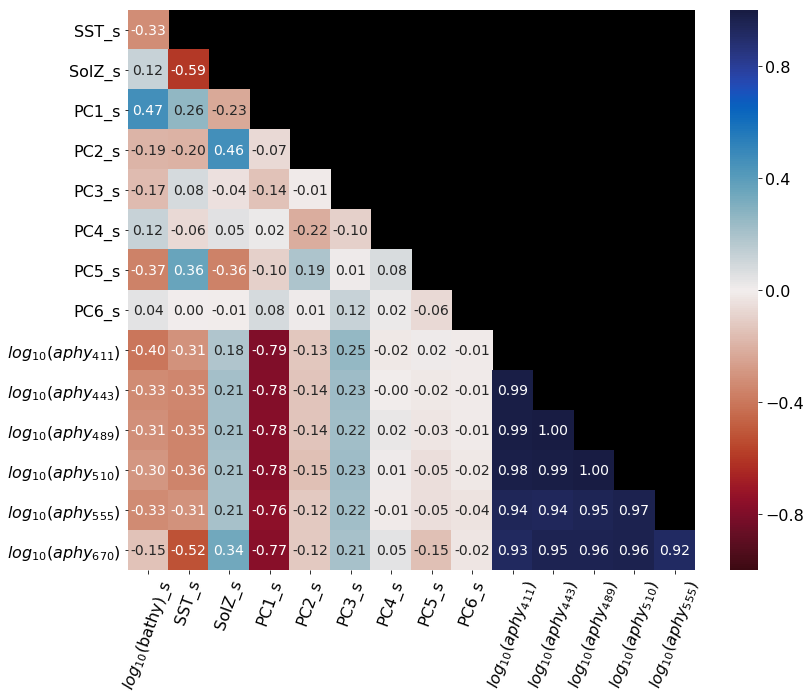

In [21]:
var_labels = [r'$log_{10}$(bathy)_s', 'SST_s', 'SolZ_s', 'PC1_s', 'PC2_s' ,'PC3_s', 'PC4_s', 'PC5_s', 'PC6_s',
             r'$log_{10}(aphy_{411})$', r'$log_{10}(aphy_{443})$', r'$log_{10}(aphy_{489})$', '$log_{10}(aphy_{510})$',
             r'$log_{10}(aphy_{555})$', r'$log_{10}(aphy_{670})$']
f, ax = pl.subplots(figsize=(12, 10))
ax=plot_pairwise_corr(ds, ax=ax, annot=True, annot_kws=dict(fontsize=14), cmap=cmo.balance_r, fmt='.2f');
ax.set_xticklabels(var_labels[:-1], rotation=70)
ax.set_yticklabels(var_labels[1:],)
ax.axhline(6, color='k')
ax.axvline(9, color='k')
f.tight_layout()
f.savefig('./figJar/reduced_datase_Pairwise.pdf', dpi=300, format='pdf')

In [22]:
feat_beg = 'x_s'
feat_end_ni = 'PC6_s'
X_s = ds.dropna().loc[:, :feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().filter(regex='log10_aphy')

In [23]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

In [24]:
datadict = dict(x_train_s = X_s_train, y_train=y_train,
               x_test_s = X_s_test, y_test=y_test)
with open('./pickleJar/BNNAphySplitDataSets.pkl', 'wb') as fb:
    pickle.dump(datadict, fb)

### Fitting 411

In [25]:
X_shared = shared(X_s_train.values)

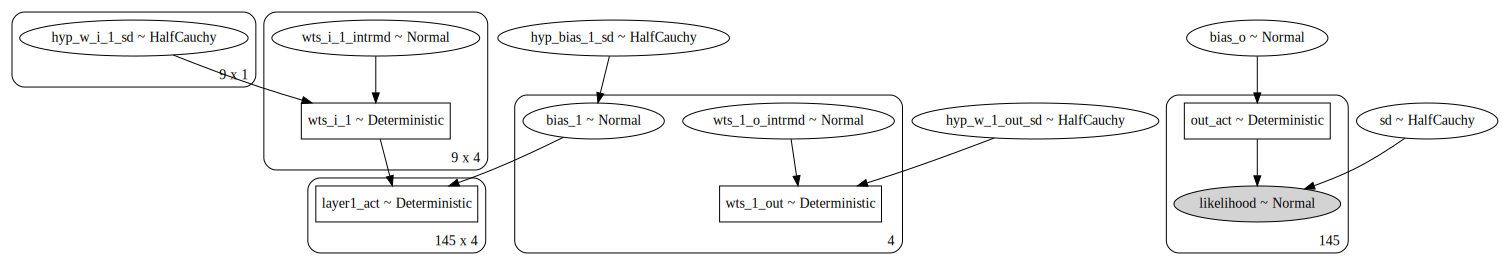

In [26]:
bnn_l1_4HL_411 = PyMCModel(bayes_nn_model_l1_h_constrained, X_shared, y_train.log10_aphy411, n_hidden=4,)
bnn_l1_4HL_411.model.name='bnn_l1_4HL_411_cons.'
bnn_l1_4HL_411.show_model()

In [ ]:
pm.sample()

In [27]:
bnn_l1_4HL_411.fit(n_samples=2000, cores=2, chains=4,
                   tune=10000,  nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 48000/48000 [2:06:38<00:00,  3.32draws/s]  
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree de

In [31]:
# pickle the models
model_dict = {bnn_l1_4HL_411.model.name: bnn_l1_4HL_411,
             bnn_l1_4HL_411_hn.model.name: bnn_l1_4HL_411_hn
             }
tag = '%s' % DT.strftime(DT.now(), format='%y%m%d_%H%M%S')
with open('./pickleJar/Models/BayesianBNN/bnn_l1_4HL_411_%s.pkl' % tag, 'wb') as fb: 
    pickle.dump(model_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
forest_labels_4 = [r'%s$\rightarrow$%d' %(feature, unit) for feature in X_s_train.columns for unit in range(1, 5)]

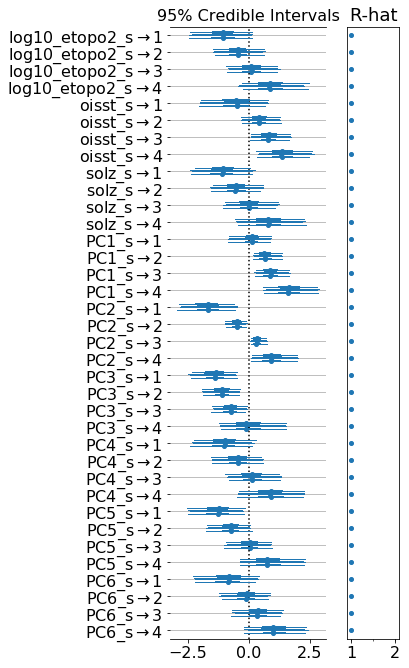

In [33]:
bnn_l1_4HL_411.show_forest(['wts_i_1_intrmd'], feat_labels=forest_labels_4)
f = pl.gcf()
f.set_figheight(10)
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_411_wts_i_1_intrmd_forestplot.pdf', dpi=300, format='pdf')

In [57]:
prior_bnn_l1_4HL_411 = pm.sample_prior_predictive(samples=1000, model=bnn_l1_4HL_411.model, vars=['wts_i_1'])

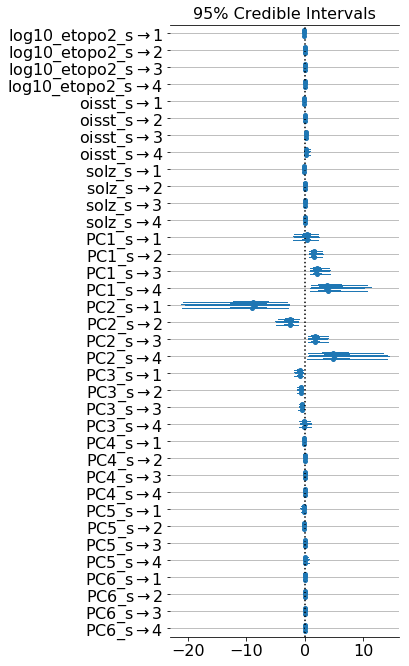

In [62]:
pm.forestplot(bnn_l1_4HL_411.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_411_wts_i_1_forestplot_no_r.pdf', dpi=300, format='pdf')

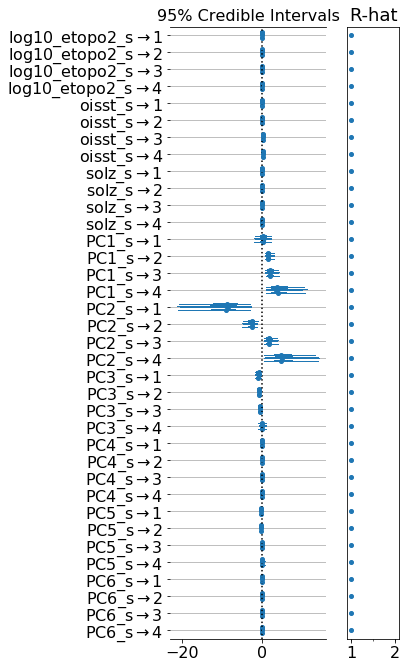

In [34]:
bnn_l1_4HL_411.show_forest(['wts_i_1'], feat_labels=forest_labels_4);
f = pl.gcf()
f.set_figheight(10)
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_411_wts_i_1_forestplot.pdf', dpi=300, format='pdf')

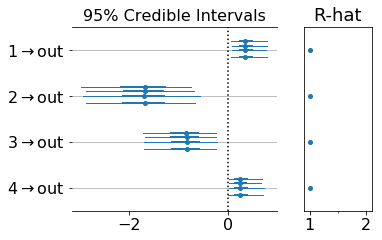

In [35]:
bnn_l1_4HL_411.show_forest(['wts_1_o_intrmd'], feat_labels=[r'%d$\rightarrow$out' % unit for unit in range(1, 5)])
f = pl.gcf()
f.set_figheight(3)
f.savefig('./figJar/forestplot_181203/bnnl16hl411_wts_1_o_intrmd.pdf',
         dpi=300, format='pdf')

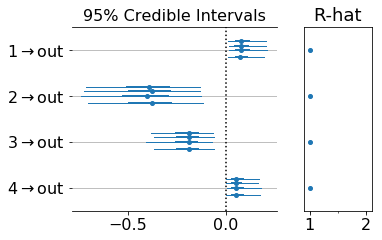

In [36]:
bnn_l1_4HL_411.show_forest(['wts_1_out'], feat_labels=[r'%d$\rightarrow$out' % unit for unit in range(1, 5)])
f = pl.gcf()
f.set_figheight(3)
f.savefig('./figJar/forestplot_181203/bnnl16hl411_wts_1_o_.pdf', format='pdf', dpi=300)

#### Checking fits on training data

100%|██████████| 2000/2000 [00:04<00:00, 491.02it/s]


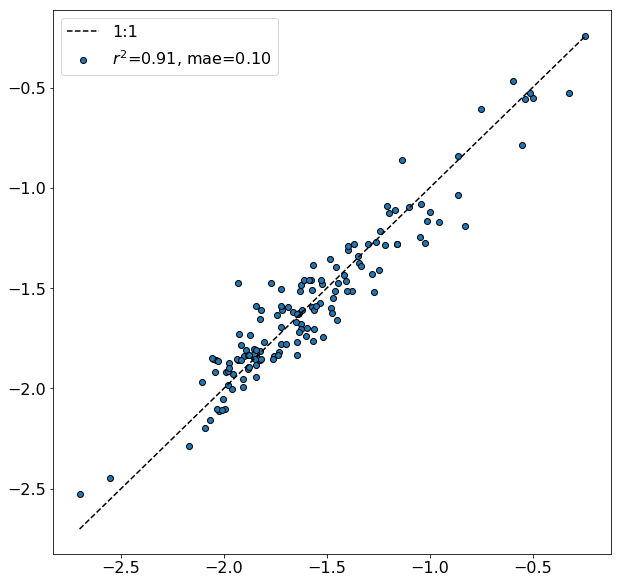

In [42]:
# Check fit on training model
ppc_train_l1_411 = bnn_l1_4HL_411.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy411, ppc_train_l1_411, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_411.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 491.93it/s]


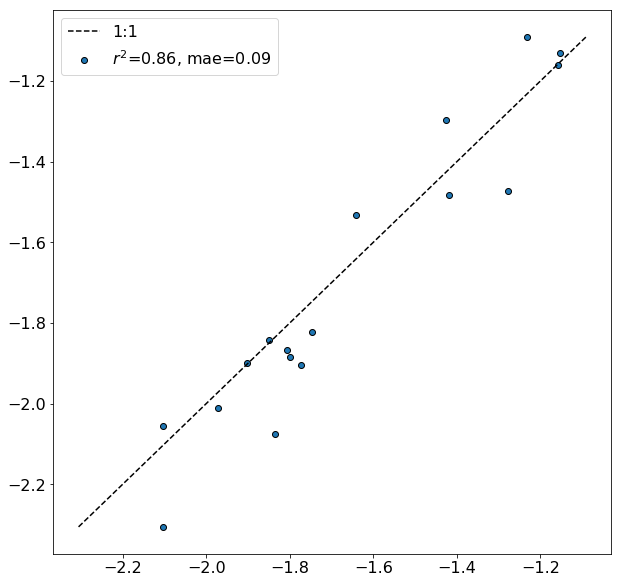

In [91]:
# Check Fit on Test Data
X_shared.set_value(X_s_test)
ppc_test_l1_411 = bnn_l1_4HL_411.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_l1_411, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_411_test.pdf', dpi=300, format='pdf')

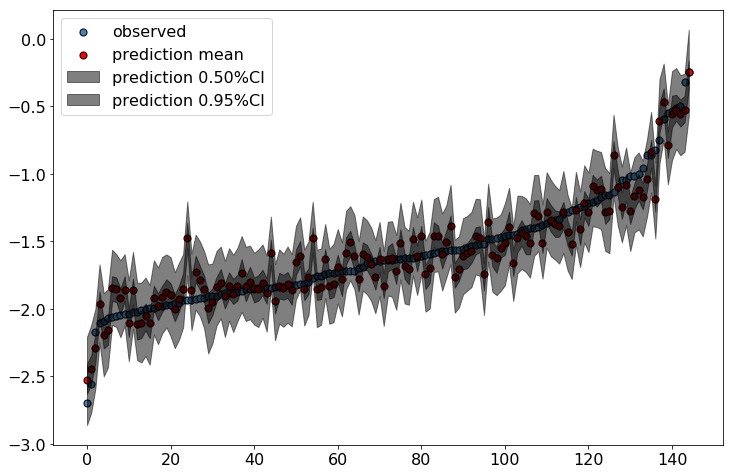

In [44]:
f, ax = pl.subplots(figsize=(12,8))
bnn_l1_4HL_411.plot_model_ppc_stats(ppc_train_l1_411, y_train.log10_aphy411, ax=ax);
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_411_95CI_50CI.pdf', dpi=300, format='pdf')

### A$\phi$_443

In [104]:
X_shared.set_value(X_s_train)
bnn_l1_4HL_443 = PyMCModel(bayes_nn_model_l1_h_constrained, X_shared, y_train.log10_aphy443, n_hidden=4,)
bnn_l1_4HL_443.model.name='bnn_l1_4HL_443_cons.'

In [105]:
bnn_l1_4HL_443.fit(n_samples=2000, cores=2, chains=4, tune=12000,
                   nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [2:41:33<00:00,  3.67draws/s]  
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 637 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6621052543003729, but should be close to 0.95. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9015106922640705, but should be close to 0.95. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for som

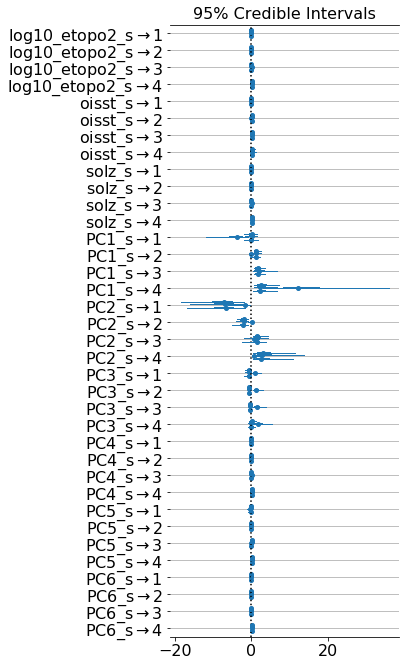

In [103]:
X_shared.set_value(X_s_train)
pm.forestplot(bnn_l1_4HL_443.trace_, varnames=['wts_i_1'],
              ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_443_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 787.04it/s]


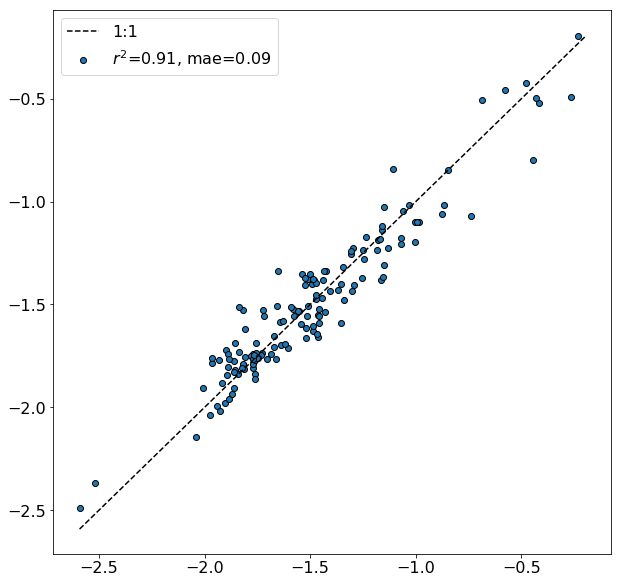

In [48]:
# Check fit on training model
ppc_train_l1_443 = bnn_l1_4HL_443.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy443, ppc_train_l1_443, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_443.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 454.56it/s]


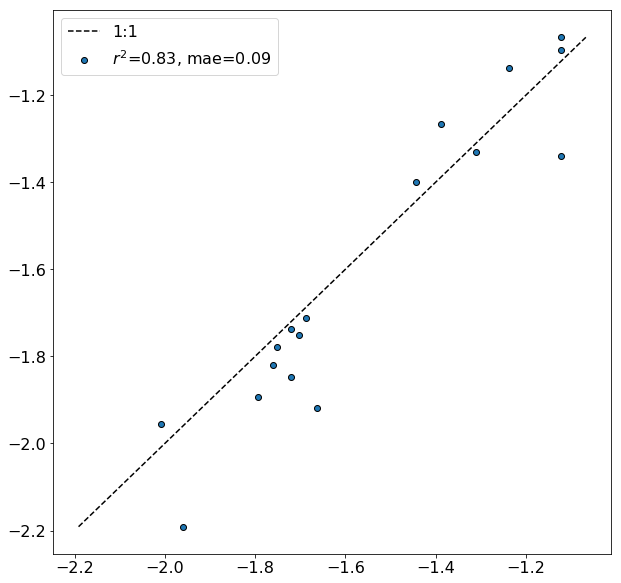

In [89]:
# Check Fit on Test Data
X_shared.set_value(X_s_test)
ppc_test_l1_443 = bnn_l1_4HL_443.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_443_test.pdf', dpi=300, format='pdf')

In [30]:
mae_test_443 = 0.09

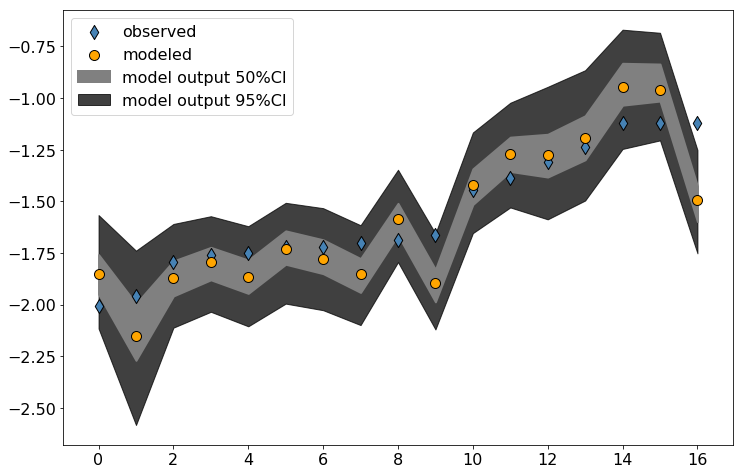

In [31]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)

### A$\phi$_489

In [63]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_489 = PyMCModel(bayes_nn_model_l1_h_constrained, X_shared, y_train.log10_aphy489, n_hidden=4,)

In [64]:
bnn_l1_4HL_489.fit(n_samples=2000, cores=2, chains=4, tune=12000,
                   nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [2:20:17<00:00,  3.68draws/s]  
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.898172139067332, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


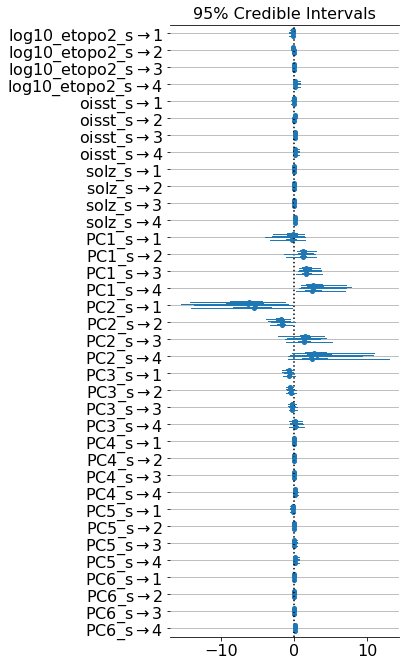

In [68]:
pm.forestplot(bnn_l1_4HL_489.trace_, varnames=['wts_i_1'], ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_489_wts_i_1_forestplot_no_r.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 824.65it/s]


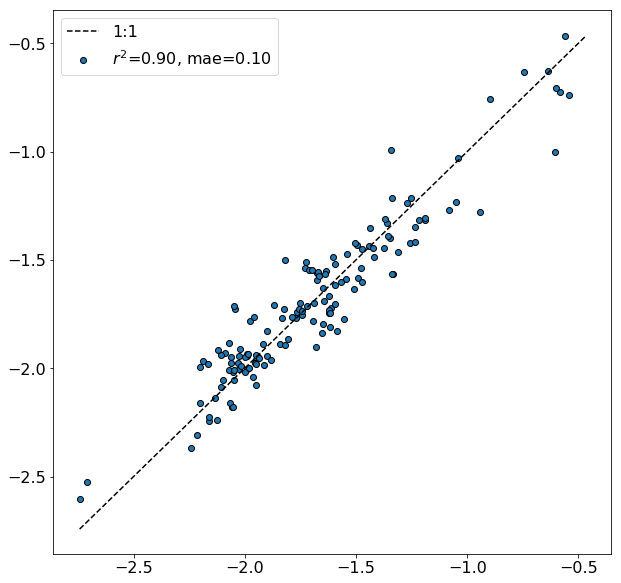

In [65]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_489 = bnn_l1_4HL_489.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy489, ppc_train_l1_489, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_489.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 459.08it/s]


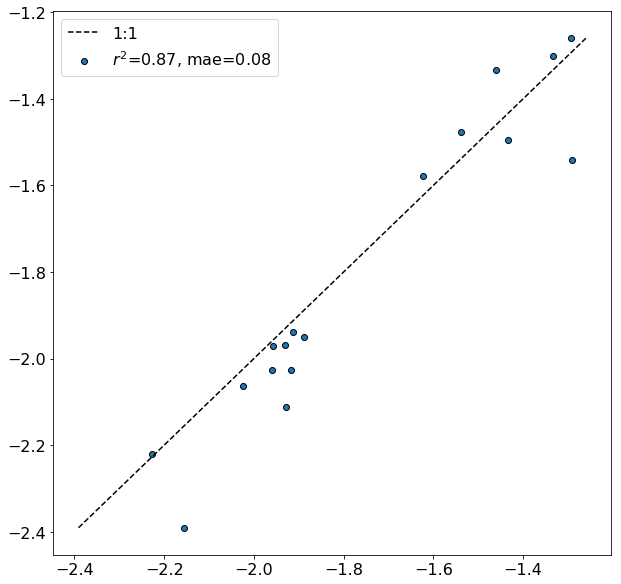

In [93]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_489 = bnn_l1_4HL_489.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_l1_489, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_489.pdf', dpi=300, format='pdf')

In [36]:
mae_test_489 = 0.08

### A$\phi$_510

In [71]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_510 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy510, n_hidden=4,)
bnn_l1_4HL_510.fit(n_samples=2000, cores=1, chains=4, tune=12000,  nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 14000/14000 [22:42<00:00, 10.28it/s]
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


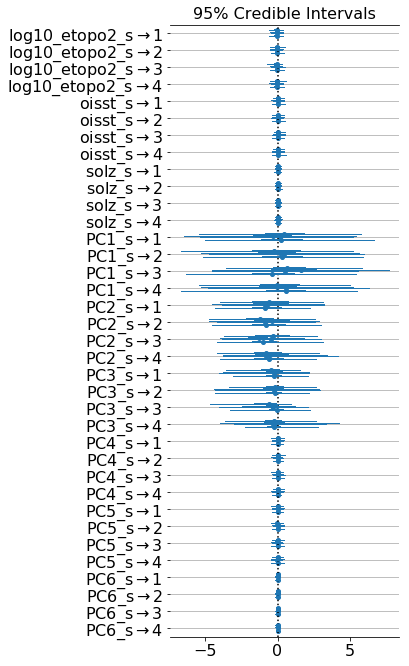

In [99]:
pm.forestplot(bnn_l1_4HL_510.trace_, varnames=['wts_i_1'],
              ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_510_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 972.52it/s]


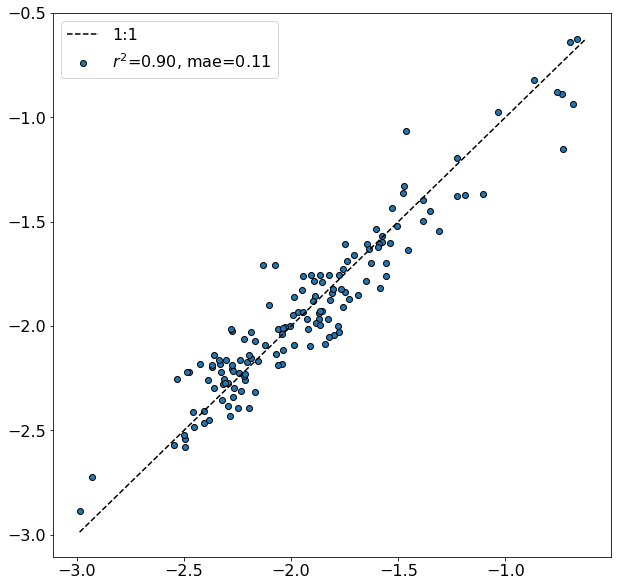

In [100]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_510 = bnn_l1_4HL_510.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy510, ppc_train_l1_510, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_510.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:02<00:00, 855.28it/s]


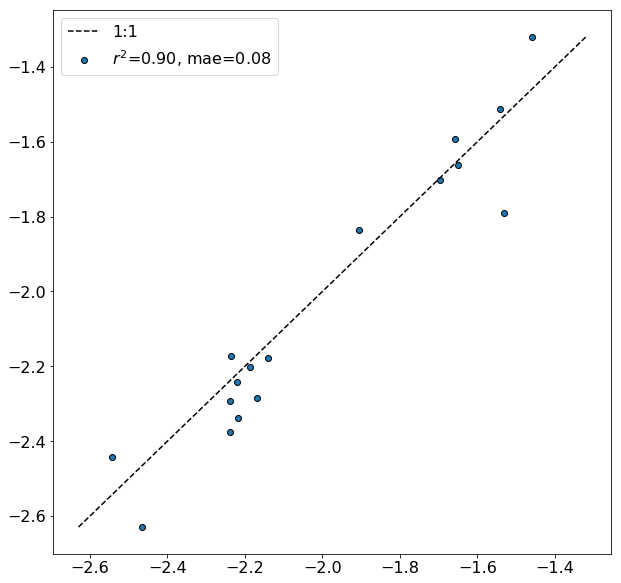

In [101]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_510 = bnn_l1_4HL_510.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_l1_510, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_510.pdf', dpi=300, format='pdf')

### A$\phi$555

In [76]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_555 = PyMCModel(bayes_nn_model_l1_h_constrained, X_shared, y_train.log10_aphy555, n_hidden=4,)
bnn_l1_4HL_555.fit(n_samples=2000, cores=3, chains=4, tune=12000,
                   nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
Sampling 4 chains: 100%|██████████| 56000/56000 [1:37:24<00:00,  5.66draws/s]  
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


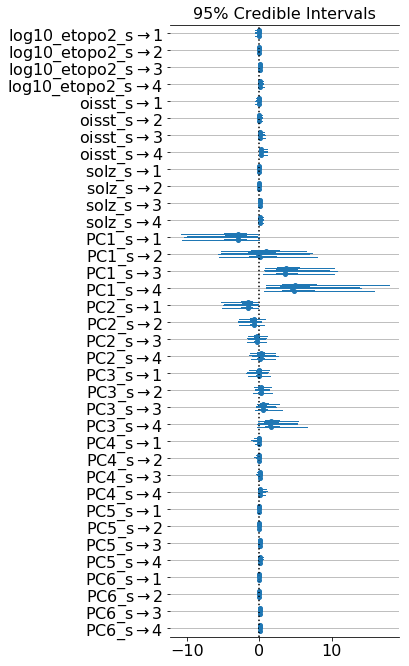

In [82]:
pm.forestplot(bnn_l1_4HL_555.trace_, varnames=['wts_i_1'],
              ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_555_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:03<00:00, 579.99it/s]


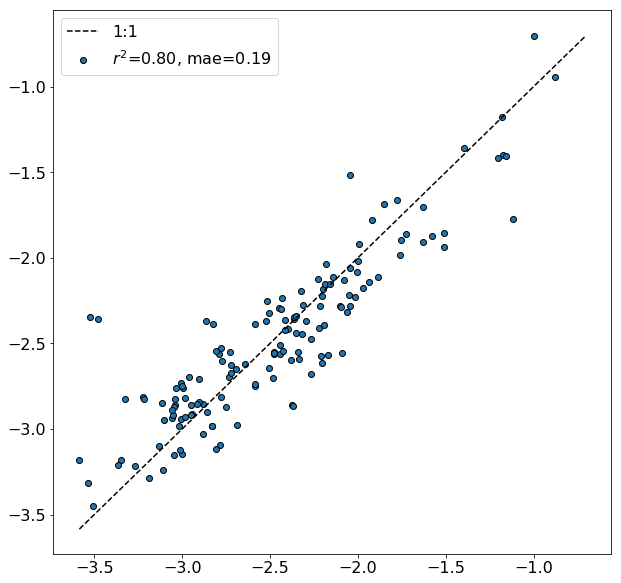

In [83]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_555 = bnn_l1_4HL_555.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy555, ppc_train_l1_555, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_555.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 438.13it/s]


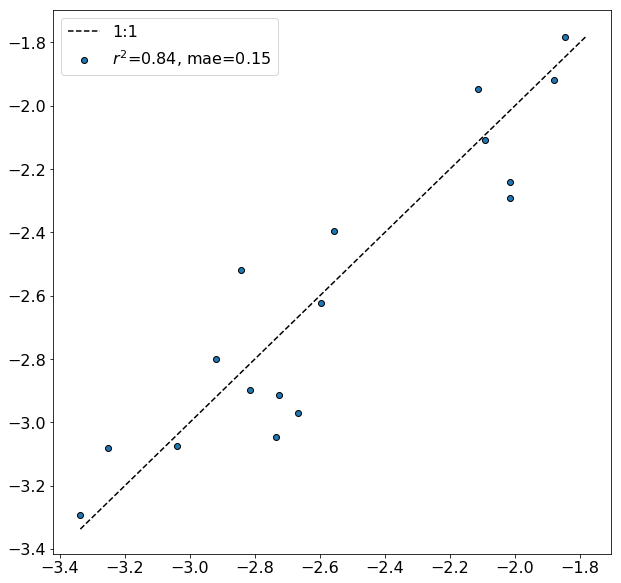

In [84]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_l1_555 = bnn_l1_4HL_555.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_l1_555, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_555.pdf', dpi=300, format='pdf')

### A$\phi$ 670

In [77]:
X_shared.set_value(X_s_train.values)
bnn_l1_4HL_670 = PyMCModel(bayes_nn_model_l1_h_constrained, X_shared, y_train.log10_aphy670, n_hidden=4,)
bnn_l1_4HL_670.fit(n_samples=2000, cores=1, chains=4, tune=12000,
                   nuts_kwargs=dict(target_accept=0.95, max_treedepth=11)
                  )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 14000/14000 [1:06:43<00:00,  3.50it/s]
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


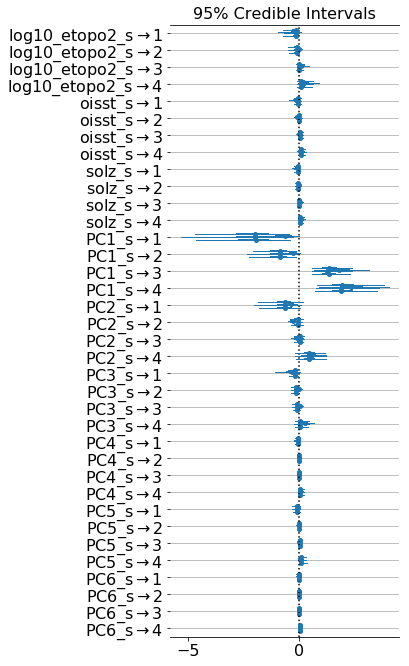

In [85]:
pm.forestplot(bnn_l1_4HL_670.trace_, varnames=['wts_i_1'],
              ylabels=forest_labels_4, rhat=False)
f = pl.gcf()
f.set_figheight(10)
ax = pl.gca()
ax.grid(axis='y')
f.savefig('./figJar/forestplot_181203/bnn_l1_4HL_670_wts_i_1_forestplot_no_r.pdf',
          dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 419.86it/s]


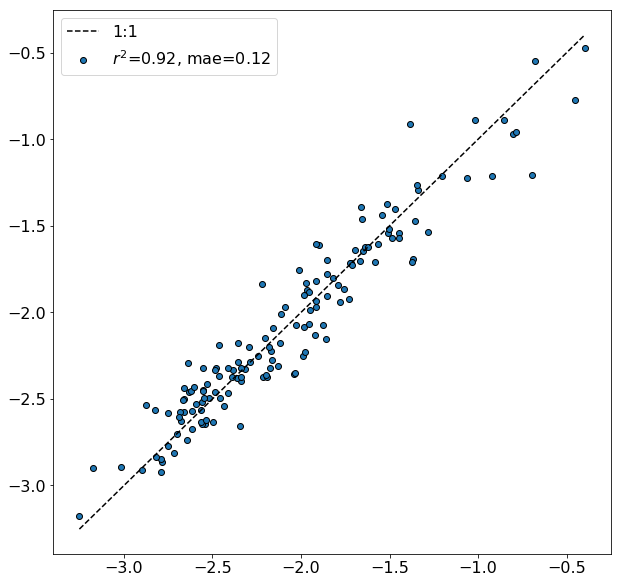

In [86]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_670 = bnn_l1_4HL_670.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_train.log10_aphy670, ppc_train_l1_670, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/train_set_fits/bnn_l1_4HL_670.pdf', dpi=300, format='pdf')

100%|██████████| 2000/2000 [00:04<00:00, 472.65it/s]


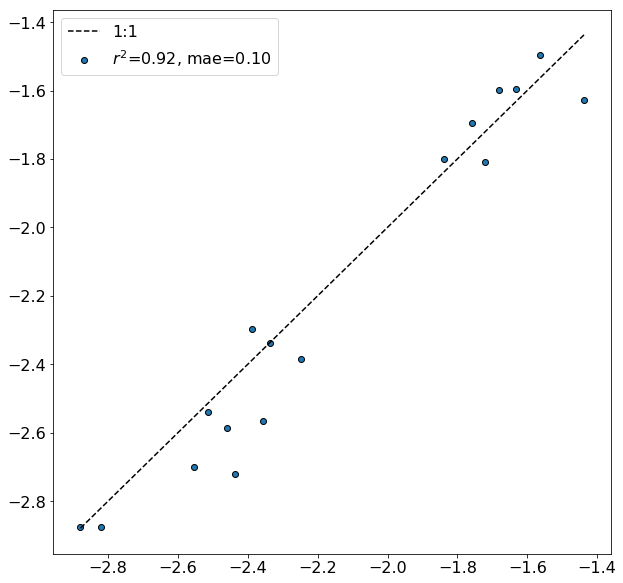

In [87]:
X_shared.set_value(X_s_test.values)
ppc_test_l1_670 = bnn_l1_4HL_670.predict(likelihood_name='likelihood')
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_l1_670, plot_1_to_1=True)
f = pl.gcf()
f.savefig('./figJar/test_set_fits/bnn_l1_4HL_670.pdf', dpi=300, format='pdf')

In [96]:
ppc_train_dict = dict(ppc_train_l1_411=ppc_train_l1_411,
                     ppc_train_l1_443=ppc_train_l1_443,
                     ppc_train_l1_489=ppc_train_l1_489,
                     ppc_train_l1_510=ppc_train_l1_510,
                     ppc_train_l1_555=ppc_train_l1_555,
                      ppc_train_l1_670=ppc_train_l1_670,
                     )
ppc_test_dict = dict(ppc_test_l1_411=ppc_test_l1_411,
                    ppc_test_l1_443=ppc_test_l1_443,
                    ppc_test_l1_489=ppc_test_l1_489,
                    ppc_test_l1_510=ppc_test_l1_510,
                    ppc_test_l1_555=ppc_test_l1_555,
                    ppc_test_l1_670=ppc_test_l1_670,
                    )
ppc_dict = dict(train=ppc_train_dict,
               test=ppc_test_dict)
with open('./pickleJar/ppcs/ppc_h_hcauchy.pkl', 'wb') as fb:
    pickle.dump(ppc_dict, fb)

In [97]:
X_shared.set_value(X_s_train)

In [98]:
bnn_l1_4HL_411.model.name = 'bnn_L1_4HL_411'
bnn_l1_4HL_443.model.name = 'bnn_L1_4HL_443'
bnn_l1_4HL_489.model.name = 'bnn_L1_4HL_489'
bnn_l1_4HL_510.model.name = 'bnn_L1_4HL_510'
bnn_l1_4HL_555.model.name = 'bnn_L1_4HL_555'
bnn_l1_4HL_670.model.name = 'bnn_L1_4HL_670'
model_dict = {bnn_l1_4HL_411.model.name: bnn_l1_4HL_411, 
              bnn_l1_4HL_443.model.name: bnn_l1_4HL_443,
              bnn_l1_4HL_489.model.name: bnn_l1_4HL_489,
              bnn_l1_4HL_510.model.name: bnn_l1_4HL_510,
              bnn_l1_4HL_555.model.name: bnn_l1_4HL_555,
              bnn_l1_4HL_670.model.name: bnn_l1_4HL_670,
             }
with open('./pickleJar/Models/BayesianBNN181210/HlfCchyHypPriors/models.pkl', 'wb') as fb:
    pickle.dump(model_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)

---

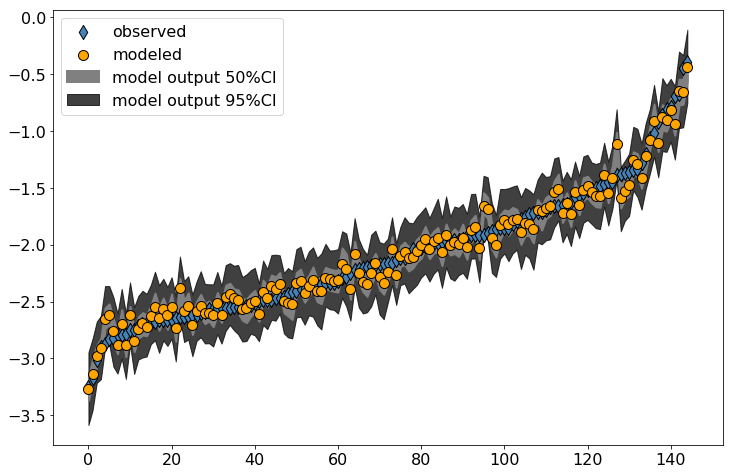

In [47]:
plot_fits_w_estimates(y_train.log10_aphy670, ppc_train_l1_670)

100%|██████████| 2000/2000 [00:02<00:00, 946.37it/s]


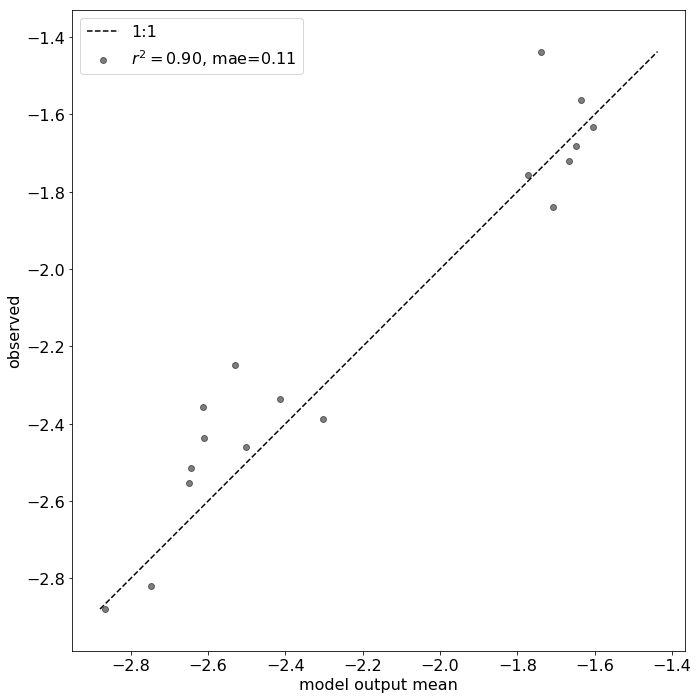

In [48]:
# Check fit on training model
X_shared.set_value(X_s_test)
ppc_test_670 = bnn_l1_4HL_670.predict(likelihood_name='likelihood')
bnn_l1_4HL_670.plot_model_fits(y_test.log10_aphy670, ppc_test_670, loss_metric='mae', );

In [49]:
mae_test_670 = 0.11

### Summary Graphs

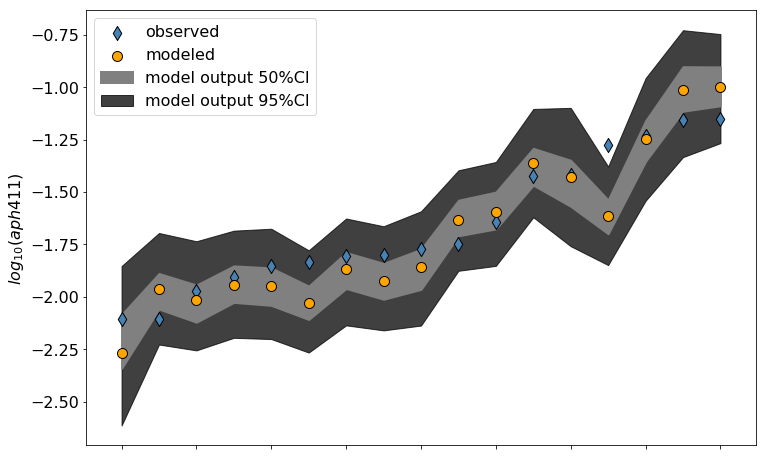

In [50]:
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_411_unc.pdf', dpi=300, format='pdf')

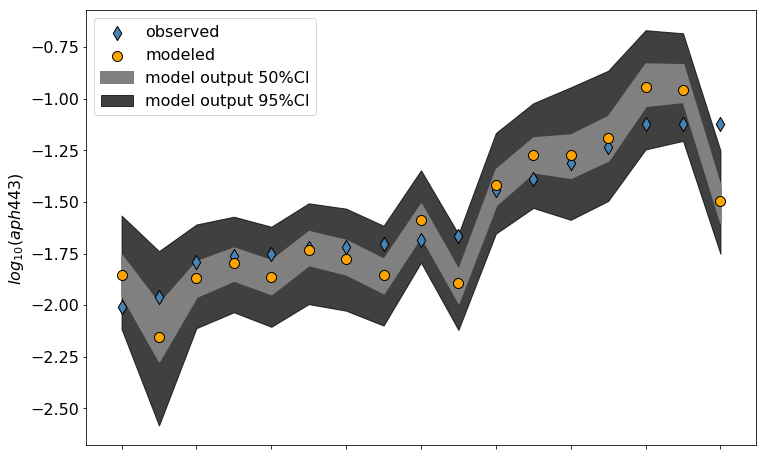

In [51]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 443)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_443_unc.pdf', dpi=300, format='pdf')

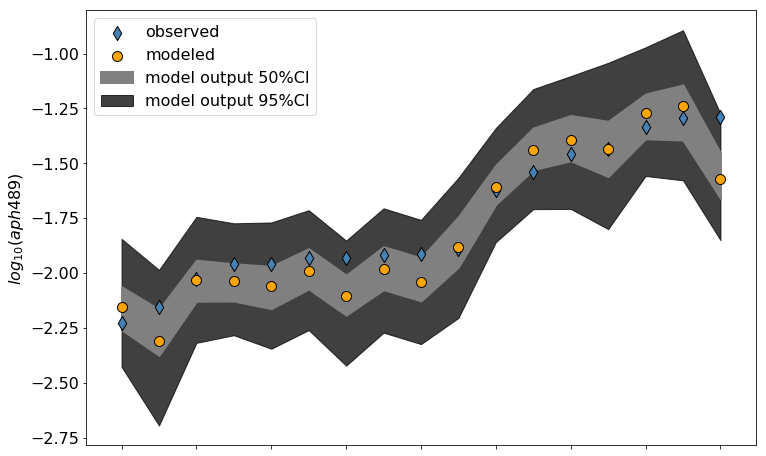

In [52]:
ax = plot_fits_w_estimates(y_test.log10_aphy489, ppc_test_489)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 489)$')
f = pl.gcf()
#f.savefig('./figJar/Single_HL_4_aphi_489_unc.pdf', dpi=300, format='pdf')

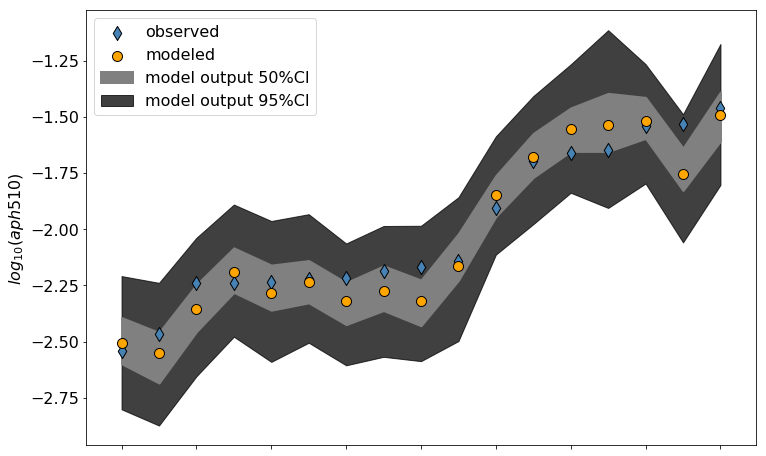

In [53]:
ax = plot_fits_w_estimates(y_test.log10_aphy510, ppc_test_510)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 510)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_510_unc.pdf', dpi=300, format='pdf')

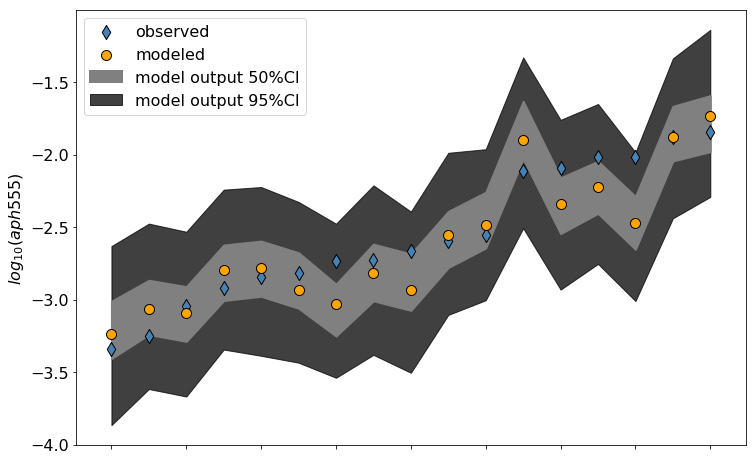

In [54]:
ax = plot_fits_w_estimates(y_test.log10_aphy555, ppc_test_555)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 555)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_555_unc.pdf', dpi=300, format='pdf')

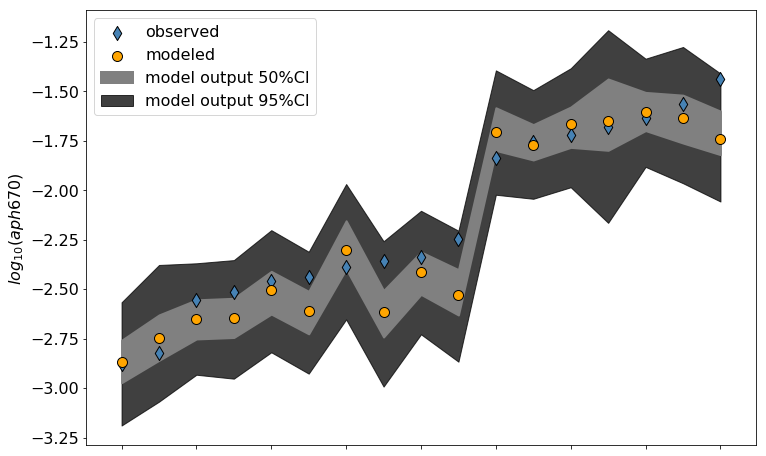

In [55]:
ax = plot_fits_w_estimates(y_test.log10_aphy670, ppc_test_670)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 670)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_670_unc.pdf', dpi=300, format='pdf')

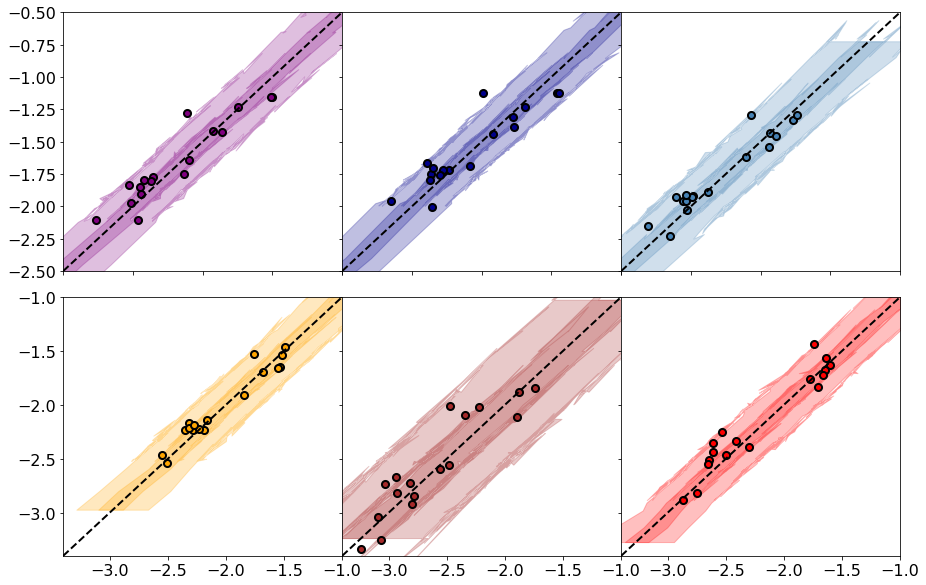

In [56]:
f, axs = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()
f.subplots_adjust(wspace=0, hspace=0.1)

uncertainty_plot_2(ppc_train_l1_411, ppc_test_411, y_test.log10_aphy411.values, y_train.log10_aphy411.values,
                  ax=axs[0], band_color='purple')
uncertainty_plot_2(ppc_train_l1_443, ppc_test_443, y_test.log10_aphy443.values, y_train.log10_aphy443.values,
                  ax=axs[1], band_color='darkblue')
uncertainty_plot_2(ppc_train_l1_489, ppc_test_489, y_test.log10_aphy489.values, y_train.log10_aphy489.values,
                  ax=axs[2], band_color='steelblue')
uncertainty_plot_2(ppc_train_l1_510, ppc_test_510, y_test.log10_aphy510.values, y_train.log10_aphy510.values,
                  ax=axs[3], band_color='orange')
uncertainty_plot_2(ppc_train_l1_555, ppc_test_555, y_test.log10_aphy555.values, y_train.log10_aphy555.values,
                  ax=axs[4], band_color='brown')
uncertainty_plot_2(ppc_train_l1_670, ppc_test_670, y_test.log10_aphy670.values, y_train.log10_aphy670.values,
                  ax=axs[5], band_color='red')
for i, ax in enumerate(axs):
    
    if i < 3:
        min_, max_ = -2.5, -0.5
        ax.set_xticklabels([])
    else:
        min_, max_ = -3.4, -1
    if i %3 != 0:
        ax.set_yticklabels([])
    ax.plot([min_, max_], [min_, max_], ls='--', color='k', lw=2, label='')
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)

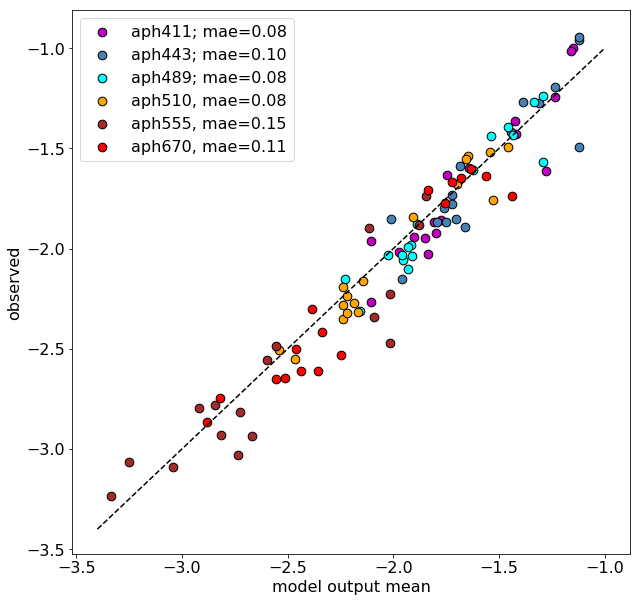

In [57]:
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m', label='aph411; mae=%.2f' % mae_test_411, s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_, label='aph443; mae=%.2f' % mae_test_443, s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_, label='aph489; mae=%.2f' % mae_test_489, s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_, label='aph510, mae=%.2f' % mae_test_510, s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_, label='aph555, mae=%.2f' % mae_test_555, s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_, label='aph670, mae=%.2f' % mae_test_670, s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
f.savefig('./figJar/Single_HL_4_aphi_test_sets.pdf', format='pdf', dpi=300)

In [129]:
bnn_l1_4HL_411.model.name = 'bnn_l1_4HL_411'
bnn_l1_4HL_443.model.name = 'bnn_l1_4HL_443'
bnn_l1_4HL_489.model.name = 'bnn_l1_4HL_489'
bnn_l1_4HL_510.model.name = 'bnn_l1_4HL_510'
bnn_l1_4HL_555.model.name = 'bnn_l1_4HL_555'
bnn_l1_4HL_670.model.name = 'bnn_l1_4HL_670'

In [130]:
pickledModelDict = {bnn_l1_4HL_411.model.name: bnn_l1_4HL_411,
                    bnn_l1_4HL_443.model.name: bnn_l1_4HL_443,
                    bnn_l1_4HL_489.model.name: bnn_l1_4HL_489,
                    bnn_l1_4HL_510.model.name: bnn_l1_4HL_510,
                    bnn_l1_4HL_555.model.name: bnn_l1_4HL_555,
                    bnn_l1_4HL_670.model.name: bnn_l1_4HL_670
                   }
with open('./pickleJar/Models/Aphi_ALL_BNN_4_HL1_ARD.pkl', 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
np.log10(0.001)

-3.0

In [61]:
10**-3.5

0.00031622776601683794